# Process Census Data

Load the raw Australian Beureau of Statistics (ABS) Census data and process it into a format that can be used for analysis. 

We use the 'SA1' geography, which is similar to LSOA in the UK.

In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from pandas.io.common import extension_to_compression
from sklearn.impute import SimpleImputer


boundary_dir = os.path.join("..", "..", "Data", "Boundary_Data")
census_dir = os.path.join("..", "..", "Data", "Census_Data")


## Read boundary data 

Read the following SA1 shapefiles:

  - 2011: [SA1_2011_AUST.shp](https://data.gov.au/data/dataset/asgs-2011-edition-boundaries) (_note that the raw data is a large geopackage file, from which I extracted the SA1 shapefile; see below_)
  - 2016: [SA1_2016_AUST.gpkg](https://data.gov.au/data/dataset/asgs-2016-edition-boundaries) (_ditto_)
  - 2021: [SA1_2021_AUST_GDA2020.shp](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files)
 

### 2021

Just open the shapefile, select inner melbourne, and rename the SA1 code column so that all years are consistent.

In [2]:
sa1_2021 = gpd.read_file(os.path.join(boundary_dir, "SA1_2021_AUST_GDA2020.shp"))
sa1_2021 = sa1_2021.loc[sa1_2021.SA4_NAME21 == "Melbourne - Inner",:]  # Select inner belbourne
sa1_2021 = sa1_2021.rename(columns={"SA1_CODE21": "SA1_Code"})
sa1_2021['SA1_Code'] = pd.to_numeric(sa1_2021['SA1_Code'])
sa1_2021 = sa1_2021.set_index("SA1_Code", drop=True)

In [3]:
sa1_2021.head()

,CHG_FLAG21,CHG_LBL21,SA2_CODE21,SA2_NAME21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
SA1_Code,,,,,,,,,,,,,,,,,
20601110601,0,No change,206011106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.1801,http://linked.data.gov.au/dataset/asgsed3/SA1/...,"POLYGON ((144.98137 -37.76553, 144.98138 -37.7..."
20601110605,0,No change,206011106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.0678,http://linked.data.gov.au/dataset/asgsed3/SA1/...,"POLYGON ((144.97139 -37.77338, 144.97151 -37.7..."
20601110606,0,No change,206011106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.0496,http://linked.data.gov.au/dataset/asgsed3/SA1/...,"POLYGON ((144.97438 -37.77347, 144.97444 -37.7..."
20601110608,0,No change,206011106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.2623,http://linked.data.gov.au/dataset/asgsed3/SA1/...,"POLYGON ((144.97955 -37.77144, 144.97960 -37.7..."
20601110609,0,No change,206011106,Brunswick East,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,AUS,Australia,0.1384,http://linked.data.gov.au/dataset/asgsed3/SA1/...,"POLYGON ((144.97220 -37.76876, 144.97231 -37.7..."


### 2016

The raw geopackage is massive and contains loads of different layers. The code below will read the `statistical_area_level_1_2016` layer and save that file. Then the code after that just reads the Melbourne data we need and I haven't saved the whole geopackage permanently.

In [4]:
sa1_2016 = gpd.read_file(os.path.join(boundary_dir, "SA1_2016_AUST.gpkg"))
sa1_2016 = sa1_2016.rename(columns={"SA1_7DIGITCODE_2016": "SA1_Code"})
sa1_2016['SA1_Code'] = pd.to_numeric(sa1_2016['SA1_Code'])
sa1_2016 = sa1_2016.set_index("SA1_Code", drop=True)

In [5]:
sa1_2016.head()

,SA1_MAINCODE_2016,STE_CODE_2016,STE_NAME_2016,geometry
SA1_Code,,,,
2100101,20101100101,2,Victoria,"MULTIPOLYGON (((143.80089 -37.55384, 143.80094..."
2100102,20101100102,2,Victoria,"MULTIPOLYGON (((143.79772 -37.55073, 143.79753..."
2100105,20101100105,2,Victoria,"MULTIPOLYGON (((143.81562 -37.55871, 143.81461..."
2100106,20101100106,2,Victoria,"MULTIPOLYGON (((143.80094 -37.55384, 143.80089..."
2100107,20101100107,2,Victoria,"MULTIPOLYGON (((143.81294 -37.55644, 143.81285..."


### 2011

The raw geopackage is massive and contains loads of different layers. The code below will read the `statistical_area_level_1_2011` layer and save that file. Then the code after that just reads the Melbourne data we need and I haven't saved the whole geopackage permanently.

In [6]:
sa1_2011 = gpd.read_file(os.path.join(boundary_dir, "SA1_2011_AUST.gpkg"))
sa1_2011 = sa1_2011.rename(columns={"SA1_7DIGITCODE_2011": "SA1_Code"})
sa1_2011['SA1_Code'] = pd.to_numeric(sa1_2011['SA1_Code'])
sa1_2011 = sa1_2011.set_index("SA1_Code", drop=True)

In [7]:
sa1_2011.head()

,SA1_MAINCODE_2011,STE_CODE_2011,STE_NAME_2011,geometry
SA1_Code,,,,
2100101,20101100101,2,Victoria,"MULTIPOLYGON (((143.80089 -37.55384, 143.80094..."
2100102,20101100102,2,Victoria,"MULTIPOLYGON (((143.79772 -37.55073, 143.79753..."
2100103,20101100103,2,Victoria,"MULTIPOLYGON (((143.74158 -37.52394, 143.73141..."
2100104,20101100104,2,Victoria,"MULTIPOLYGON (((143.79408 -37.55632, 143.79333..."
2100105,20101100105,2,Victoria,"MULTIPOLYGON (((143.81562 -37.55871, 143.81461..."


### Check three maps of the census boudaries

Reproject the data so that they are consistent with the sensors and then check them with a map

In [8]:
for gdf in [sa1_2011, sa1_2016, sa1_2021]:
    gdf.to_crs(epsg=4326, inplace=True)

Load the sensors so that we can make sure the CRS is consistent etc

In [9]:
sensors_df = pd.read_csv(os.path.join("..", "..", "Cleaned_data", "SensorData", "sensor_locations.csv"))
sensors_gdf = (gpd.GeoDataFrame(sensors_df, geometry=gpd.points_from_xy(sensors_df['Longitude'], sensors_df['Latitude'])).
               set_crs(epsg=4326, inplace=True))

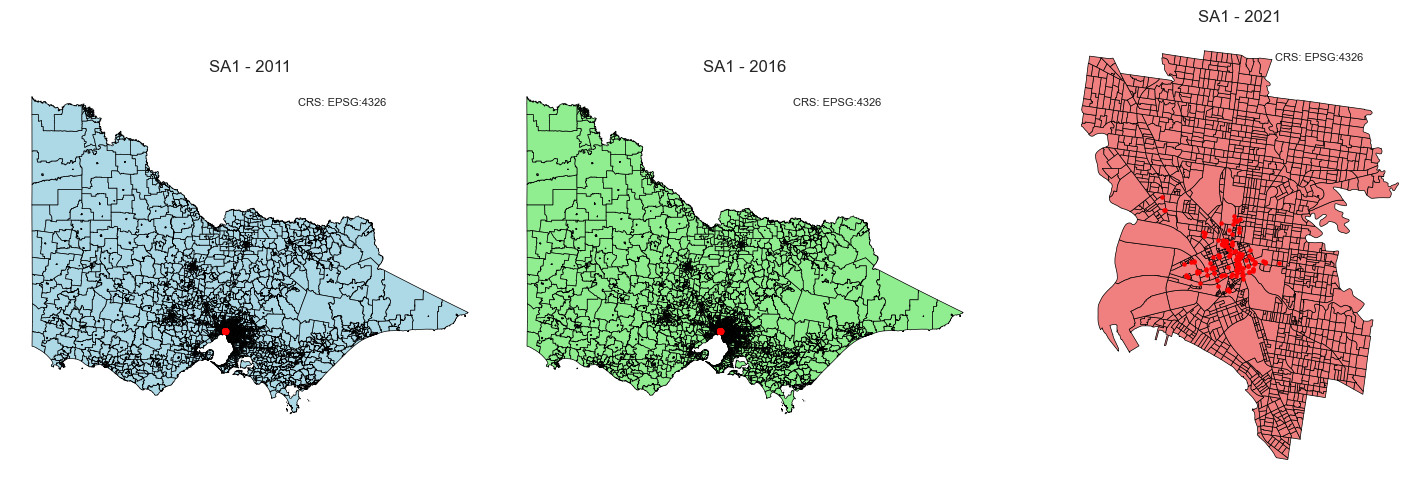

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each map
sa1_2011.plot(ax=axes[0], color="lightblue", edgecolor="black", linewidth=0.5 )
axes[0].set_title("SA1 - 2011")


sa1_2016.plot(ax=axes[1], color="lightgreen", edgecolor="black", linewidth=0.5 )
axes[1].set_title("SA1 - 2016")


sa1_2021.plot(ax=axes[2], color="lightcoral", edgecolor="black", linewidth=0.5 )
axes[2].set_title("SA1 - 2021")

for ax, sa1 in zip(axes, [sa1_2011, sa1_2016, sa1_2021]):
    sensors_gdf.plot(ax=ax, color="red", markersize=5)  # Add the sensors
    ax.text(0.6, 0.95, f"CRS: {sa1.crs}", transform=ax.transAxes, fontsize=8, verticalalignment='top')  # Show the CRS
    ax.set_axis_off()  # Remove axes for a cleaner look

plt.tight_layout()
plt.show()

## Read Census data and join to the gdfs
Read the following files, all downloaded using the [ABS TableBuilder](https://tablebuilder.abs.gov.au/webapi/jsf/tableView/tableView.xhtml). The data are stored in [Data/Census_Data](../../Data/Census_Data) 

Note that for most files I needed to delete unnecessary rows in the csv file in the top (headers) and bottom (totals). I also sometimes had to slightly adjust the columns as the headers weren't always on the same row, and renamed a couple of longer ones to something more manageable (like the 'SA1 code').

The raw data before any changes are available in [this directory](../../Data/Census_Data/raw).

  - **2011**
    - `2011-InnerMel-Age.csv`: SA1 by Greater Capital City Statistical Areas (UR) by Age in Single Years (AGEP)
    - `2011-InnerMel-Income.csv`: SA1 by Greater Capital City Statistical Areas (UR) by Total Personal Income (weekly) (INCP)
    - `2011-InnerMel-HighestYearOfSchool.csv`: SA1 by Greater Capital City Statistical Areas (UR) by Highest Year of School Completed (HSCP)
  - **2016** 
    - `2016-InnerMel-Age.csv`: SA1 (UR) by AGEP Age
    - `2016-InnerMel-Income.csv`: SA1 (UR) by INCP Total Personal Income (weekly) 
    - `2016-InnerMel-HighestYearOfSchool.csv`: SA1 (UR) by HSCP Highest Year of School Completed
  - **2021** 
    - `2021-InnerMel-Age.csv`: SA1 (UR) by AGEP Age
    - `2021-InnerMel-Income.csv`: SA1 (UR) by INCP Total Personal Income (weekly)
    - `2021-InnerMel-HighestYearOfSchool.csv`: SA1 (UR) by HSCP Highest Year of School Completed

In [11]:
# Define some functions to get a single number out of the census data for age, income and schooling

# AGE 

def calc_mean_age(age_df):
    """Return the mean ages as an array for all rows in the DataFrame"""
    ages = np.arange(len(age_df.columns) )  # Array of ages starting from 0
    #population_counts = age_df.iloc[:, 1:]    # Select only age columns
    #mean_age = (population_counts * ages).sum(axis=1) / population_counts.sum(axis=1)
    # Sum across the columns (axis=1)
    mean_age = (age_df * ages).sum(axis=1) / age_df.sum(axis=1)
    return mean_age

# INCOME

# Function to extract income range midpoint from column name
def get_midpoint(col_name):
    # Extract the range without anything in parentheses
    base_range = re.search(r'^[^()]+', col_name).group().strip()
    
    # Handle different cases
    if '-' in base_range:
        low, high = [int(x.replace('$', '').replace(',', '')) for x in base_range.split('-')]
        return (low + high) / 2
    elif 'Negative' in base_range or 'Nil' in base_range:
        return 0
    elif 'or more' in base_range:
        low = int(base_range.replace('$', '').replace(',', '').split(' ')[0])
        # No idea what the upper range shoud be
        return low * 2 
    
    return 0  # For 'Not stated' or 'Not applicable'

def calc_mean_income(income_df):
    """Return the mean incomes as an array for all rows in the DataFrame"""
    income_columns = income_df.columns  # The SA code is the index, so all columns relate to 
    midpoints = [get_midpoint(col) for col in income_columns]
    #print(midpoints)

    # Calculate the weighted mean income per row
    income_counts = income_df[income_columns].fillna(0)  # Use zero for any missing values in counts
    mean_income = (income_counts * midpoints).sum(axis=1) / income_counts.sum(axis=1)
    return mean_income
    

# SCHOOL (last year of school finished)
# Map text descriptions to numbers
_year_dict = {
    "Year 12 or equivalent": 12,
    "Year 11 or equivalent": 11,
    "Year 10 or equivalent": 10,
    "Year 9 or equivalent": 9,
    "Year 8 or below": 8,
    "Did not go to school": 7
}
_ages = [_year_dict[col] for col in _year_dict.keys()]

def calc_mean_school_year(school_df):
    """Return the mean year of school completion for each row in the DataFrame"""
    school_counts = school_df[list(_year_dict.keys())]
    mean_scool_year = (school_counts * _ages).sum(axis=1) / school_counts.sum(axis=1)
    return mean_scool_year
    

Read all of the data and join to the spatial data in a loop. Not that for some areas there may be no counts (e.g. no one in that area, or for the few people in the area they have ticked 'not stated' or 'not applicable'). In these cases the mean will be NaN. We could replace these with 0s but I think that is misleading, so instead we will just impute the values with the mean. If you want to see the implications of this then set `imputer=None` in the cell below and then look at the map in the following cell.


In [12]:
# An imputer to replace NaNs with something sensible
#imputer = None
imputer = SimpleImputer(strategy='median')

for year, gdf in [(2011, sa1_2011), (2016, sa1_2016), (2021, sa1_2021)]:
    age = pd.read_csv(os.path.join(census_dir, f"{year}-InnerMel-Age.csv"))
    income = pd.read_csv(os.path.join(census_dir, f"{year}-InnerMel-Income.csv"))
    school = pd.read_csv(os.path.join(census_dir, f"{year}-InnerMel-HighestYearOfSchool.csv"))
    # Perform some operations on all three:
    for x in [age, income, school]:
        x['SA1_Code'] = pd.to_numeric(x['SA1_Code'])  # Convert to numeric
        x.set_index("SA1_Code", inplace=True)  # Makes joining easier
        del x['Total']  # All of them have a 'total' column that we don't want
        # Some have columns called 'Unnamed: 0' etc. that we don't want
        for col in x.columns:
            if 'Unnamed: ' in col:
                del x[col]
    
    # Check the input data are the same length (same number of areas) and the codes are the same
    assert len(age) == len(income) == len(school)
    assert age.index.equals(income.index) and age.index.equals(school.index)
    
    ## Age
    age['mean_age'] = calc_mean_age(age)
    gdf['mean_age'] = gdf.join(age)["mean_age"]
    if imputer is not None:
        gdf['mean_age'] = imputer.fit_transform( gdf[['mean_age']].values)  # The [[]] is to reshape the data since the imputer expects a 2D array
    #print(f"{year} age: {len(gdf[gdf.mean_age.notnull()])} / {len(age)} joined.")
    
    
    # Income
    income['mean_income'] = calc_mean_income(income)
    gdf['mean_income'] = gdf.join(income)["mean_income"]
    if imputer is not None:
        gdf['mean_income'] = imputer.fit_transform( gdf[['mean_income']].values)
    #print(f"{year} income: {len(gdf[gdf.mean_income.notnull()])} / {len(income)} joined.")

    
    # School
    school['mean_school_year'] = calc_mean_school_year(school)
    gdf['mean_school_year'] = gdf.join(school)["mean_school_year"]
    if imputer is not None:
        gdf['mean_school_year'] = imputer.fit_transform( gdf[['mean_school_year']].values)
    #print(f"{year} school: {len(gdf[gdf.mean_school_year.notnull()])} / {len(school)} joined.") 
    
    # Finally drop any areas that we don't have census data for (can choose age, income or school dfs as we already
    # know that their indices are identical.
    # (Can't use loc, as in the line below, as this doesn't have an 'inplace' parameter)
    #gdf = gdf.loc[gdf.index.isin(age.index), :]
    gdf.drop( gdf.index.difference(age.index), inplace=True)
    
    
    

In [13]:
# TODO manually check a couple of the calculations

Map those thre variables across the three years to check they look OK

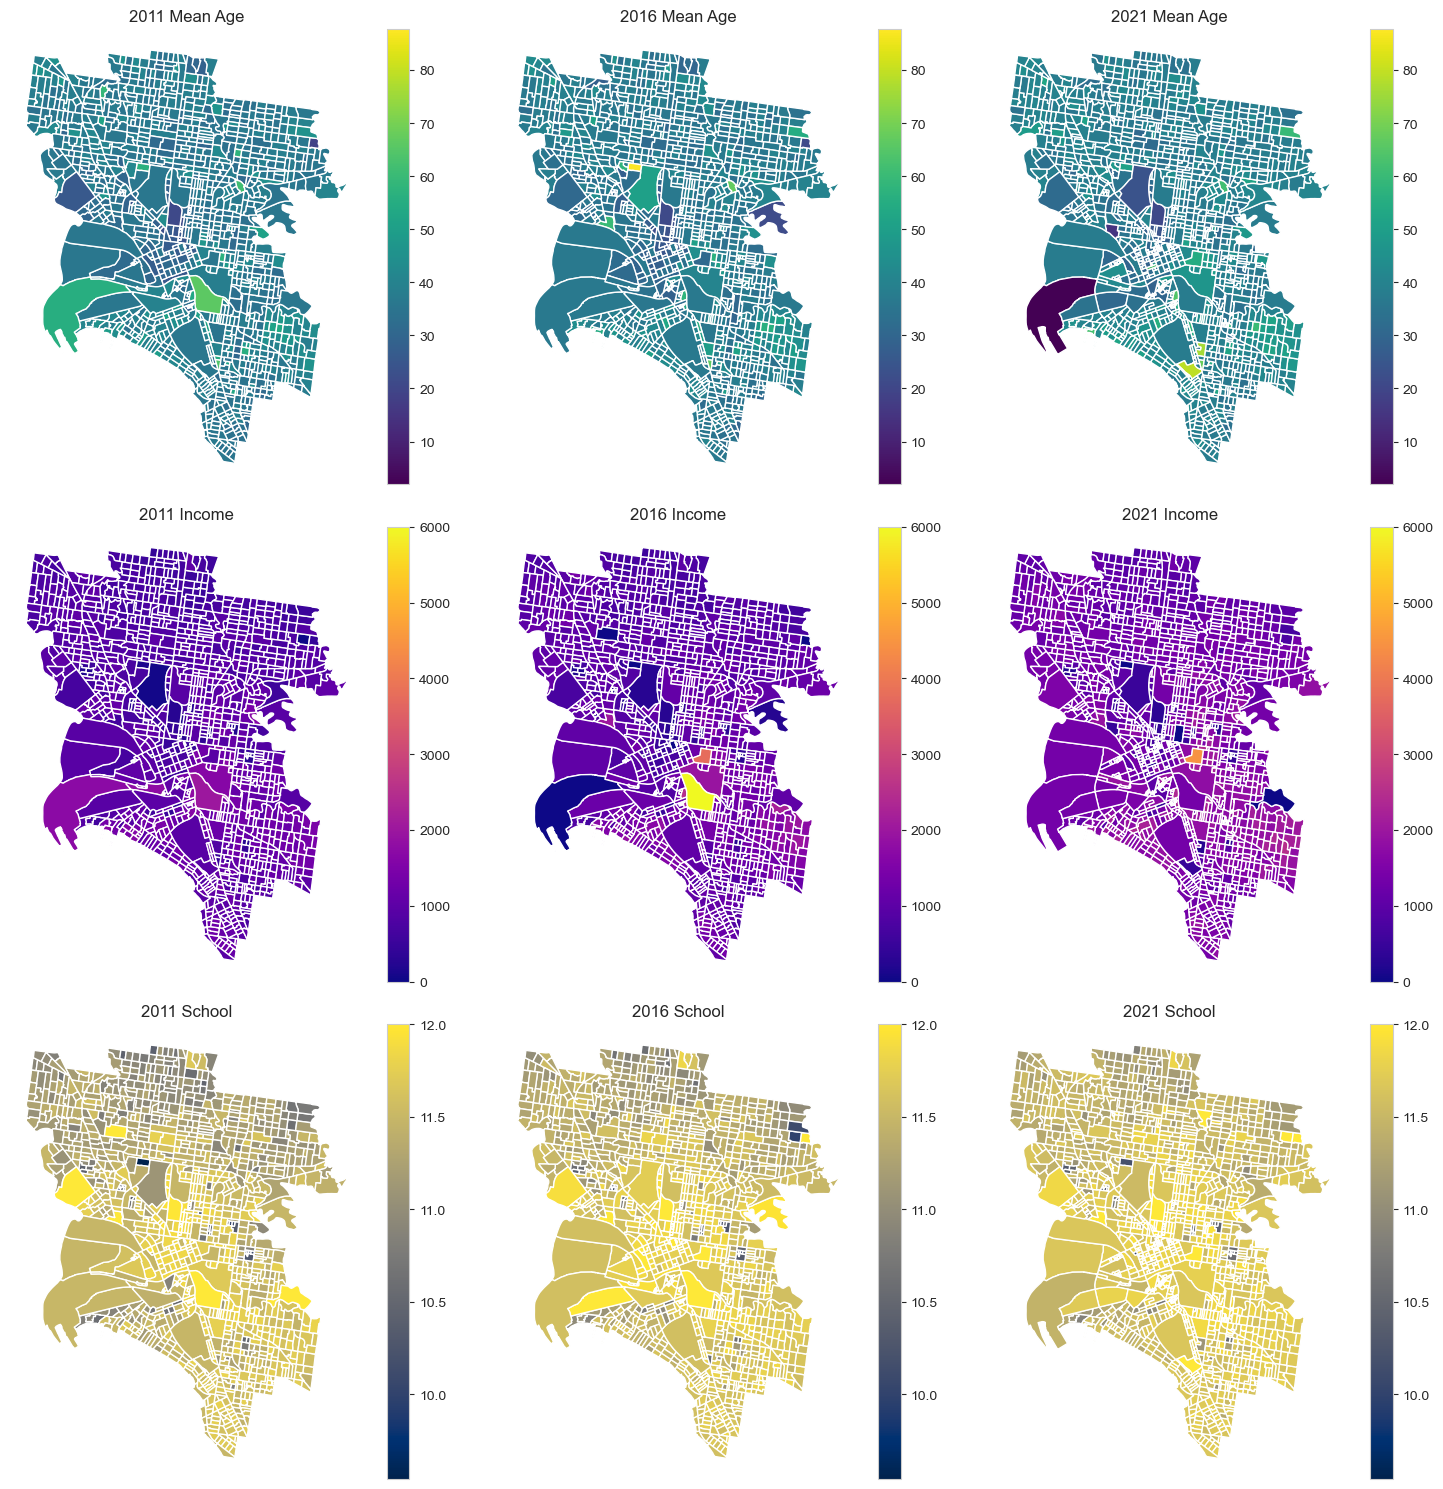

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Set up a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Determine color scales for each variable across all years
age_vmin, age_vmax = (
    min(sa1_2011['mean_age'].min(), sa1_2016['mean_age'].min(), sa1_2021['mean_age'].min()),
    max(sa1_2011['mean_age'].max(), sa1_2016['mean_age'].max(), sa1_2021['mean_age'].max())
)
income_vmin, income_vmax = (
    min(sa1_2011['mean_income'].min(), sa1_2016['mean_income'].min(), sa1_2021['mean_income'].min()),
    max(sa1_2011['mean_income'].max(), sa1_2016['mean_income'].max(), sa1_2021['mean_income'].max())
)
school_vmin, school_vmax = (
    min(sa1_2011['mean_school_year'].min(), sa1_2016['mean_school_year'].min(), sa1_2021['mean_school_year'].min()),
    max(sa1_2011['mean_school_year'].max(), sa1_2016['mean_school_year'].max(), sa1_2021['mean_school_year'].max())
)

# Plot 'mean_age' for each year with consistent color scale
sa1_2011.plot(column='mean_age', cmap='viridis', legend=True, vmin=age_vmin, vmax=age_vmax, ax=axes[0, 0])
axes[0, 0].set_title('2011 Mean Age')
sa1_2016.plot(column='mean_age', cmap='viridis', legend=True, vmin=age_vmin, vmax=age_vmax, ax=axes[0, 1])
axes[0, 1].set_title('2016 Mean Age')
sa1_2021.plot(column='mean_age', cmap='viridis', legend=True, vmin=age_vmin, vmax=age_vmax, ax=axes[0, 2])
axes[0, 2].set_title('2021 Mean Age')

# Plot 'income' for each year with consistent color scale
sa1_2011.plot(column='mean_income', cmap='plasma', legend=True, vmin=income_vmin, vmax=income_vmax, ax=axes[1, 0])
axes[1, 0].set_title('2011 Income')
sa1_2016.plot(column='mean_income', cmap='plasma', legend=True, vmin=income_vmin, vmax=income_vmax, ax=axes[1, 1])
axes[1, 1].set_title('2016 Income')
sa1_2021.plot(column='mean_income', cmap='plasma', legend=True, vmin=income_vmin, vmax=income_vmax, ax=axes[1, 2])
axes[1, 2].set_title('2021 Income')

# Plot 'school' for each year with consistent color scale
sa1_2011.plot(column='mean_school_year', cmap='cividis', legend=True, vmin=school_vmin, vmax=school_vmax, ax=axes[2, 0])
axes[2, 0].set_title('2011 School')
sa1_2016.plot(column='mean_school_year', cmap='cividis', legend=True, vmin=school_vmin, vmax=school_vmax, ax=axes[2, 1])
axes[2, 1].set_title('2016 School')
sa1_2021.plot(column='mean_school_year', cmap='cividis', legend=True, vmin=school_vmin, vmax=school_vmax, ax=axes[2, 2])
axes[2, 2].set_title('2021 School')

# Hide axes for a cleaner look
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

Optionally write them out for analysis in a GIS (mostly for sense checking, particularly some of those outliers)

## Write out the census data

Write one spatial file that has the year, the appropriate SA geometry, and the three variables (age, income, school). (_Unlike other data I can't write out the lat/lon because it's better to assoiciate the sensors with the SA boundaries rather than a centroid_).

These data are later joined to the sensors in [FormatDataForModelling.ipynb](../6.%20PrepareDataForModelling/FormatDataForModelling.ipynb)

In [15]:
# Use 2011 to create the df then add the remaining two years 
gdf_out = sa1_2011.loc[:, ['mean_age', 'mean_income', 'mean_school_year', 'geometry']].assign(year=2011).copy()

for year, gdf in [(2016, sa1_2016), (2021, sa1_2021)]:
    # Append the census data in one go, assigning the age and lat/lon columns at the same time
    gdf_out = pd.concat( [gdf_out, 
                          gdf.loc[:, ['mean_age', 'mean_income', 'mean_school_year', 'geometry']].assign(year=year)],
                         ignore_index=True)
    
# Check we haven't lost any rows
assert len(gdf_out) == len(sa1_2011) + len(sa1_2016) + len(sa1_2021)
gdf_out

,mean_age,mean_income,mean_school_year,geometry,year
0,36.364532,842.576744,11.192513,"MULTIPOLYGON (((144.97166 -37.75947, 144.97180...",2011
1,38.194222,669.690984,11.222008,"MULTIPOLYGON (((144.96636 -37.76121, 144.96628...",2011
2,39.627273,703.292494,11.070122,"MULTIPOLYGON (((144.96784 -37.76271, 144.96776...",2011
3,35.452703,892.709936,11.345098,"MULTIPOLYGON (((144.97120 -37.76436, 144.97102...",2011
4,38.629371,919.901254,11.276978,"MULTIPOLYGON (((144.96640 -37.76551, 144.96633...",2011
...,...,...,...,...,...
3859,39.199507,1604.957944,11.715210,"POLYGON ((144.99116 -37.81638, 144.99148 -37.8...",2021
3860,40.381679,2052.780374,11.862069,"POLYGON ((145.00312 -37.81628, 145.00424 -37.8...",2021
3861,34.922481,1837.184539,11.850829,"POLYGON ((145.01399 -37.82014, 145.01329 -37.8...",2021
3862,37.676712,1742.924433,11.699164,"POLYGON ((144.99494 -37.81624, 144.99496 -37.8...",2021


In [16]:
dir = os.path.join("..", "..", "Cleaned_data", "CensusData")
os.makedirs(dir, exist_ok=True)
gdf_out.to_file(os.path.join(dir, "census_data.gpkg"), driver="GPKG")